**Quantitative X-Ray Imaging: Tutorial 07**   
*Julia Herzen, Franziska Hinterdobler, Sara Savatović, Sami Wirtensohn*   

# Propagation-based phase retrieval

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import zoom
import tifffile
import xraylib

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (10,6)

Define useful functions as we will need complex refractive numbers for different materials and energies.

In [2]:
def get_n(name, E, density=None):
    """
    Get compound refractive index values: beta, delta, mu.

    Parameters
    ----------
    name : string
        Compound chemical composition or compound name from the list
        xraylib.GetCompoundDataNISTList().
    E : array
        Energy or list of energies in keV.
    density : float, optional
        Density of the compound in g/cm³. If the compound is from the
        NISTList it is not required. Check compound specifications with 
        xraylib.GetCompoundDataNISTByName(name)

    Returns
    ----------
    out : dictionary
        Values in dictionary entries "name", beta", "delta", "mu".
    """
    
    if density is None:
        try:
            density = xraylib.GetCompoundDataNISTByName(name)['density']
        except:
            print('Specify density, compound not in NIST database.')
            return

    def _n(name, E, density):
        beta  = xraylib.Refractive_Index_Im(name, E+.0, density)
        delta = 1 - xraylib.Refractive_Index_Re(name, E+.0, density)
        lam = xraylib.KEV2ANGST * 1e-10 / E  # in m
        mu = beta * 4 * np.pi / lam
        return dict(name=name, beta=beta, delta=delta, mu=mu)

    if np.ndim(E)==0:
        E = [E]
    compound = np.array([_n(name, e, density)['name'] for e in E]).squeeze()
    beta = np.array([_n(name, e, density)['beta'] for e in E]).squeeze()
    delta = np.array([_n(name, e, density)['delta'] for e in E]).squeeze()
    mu = np.array([_n(name, e, density)['mu'] for e in E]).squeeze()
    out = dict(name=compound, beta=beta, delta=delta, mu=mu)

    return out

## Single-distance phase retrieval according to Paganin and Weitkamp

Last exercise, you were introduced to near-field wave propagation and thickness retrieval based on the method proposed by [Paganin et al. (2002)](https://doi.org/10.1046/j.1365-2818.2002.01010.x) and described by [Weitkamp et al. (2011)](https://doi.org/10.1107/s0909049511002895). This method utilizes the transport of intensity equation (TIE). The final expression for the thickness of the sample you retrieved was
$$
T(x,y) = -\frac{1}{\mu} \mathrm{ln}\left(\mathcal{F}^{-1}\bigg\{ \frac{\mathcal{F}[I(x,y)]}{1+z\delta\mu^{-1}(u^{2}+v^{2})} \bigg\} \right) \, .
$$
The thickness is related to the phase in the following way (under which assumption?)
$$
\varphi(x,y) = -\frac{2\pi\delta}{\lambda}\cdot T(x,y).
$$
The phase can also be directly retrieved without first calculating the thickness via
$$
\varphi(x,y) = \frac{\delta}{2\beta}\text{ln}\bigg(\mathcal{F}^{-1}\bigg\{\frac{\mathcal{F}[I(x,y)/I_0(x,y)]}{1+[\lambda z \delta/4\pi\beta](u^2 + v^2)}\bigg\}\bigg).
$$
What are the key assumptions in this method?
* single material
* homogeneous object
* sufficiently thin
* plane-wave radiation of uniform density
* monochromatic
* we are in the near field

Set the acquisition and material parameters, like energy and wavelength, propagation distance, detector pixel size, etc. ...

In [3]:
def nf_prop(a, z, lam, px):
    """\
    Near field free-space propagation of a over a distance z, with wavelength
    lam. px defines the sampling distance in fourier space given by the detector pixel size.
    """
    M, N = a.shape
    u = 2. * np.pi * np.fft.fftfreq(img.shape[1], d=px)
    v = 2. * np.pi * np.fft.fftfreq(img.shape[0], d=px)
    uu, vv = np.meshgrid(u, v, indexing='xy')
    u2 = uu**2 + vv**2
    kernel = np.exp(-1j * z  * lam * u2 / (4*np.pi)) # the definition can be found in the lecture or in Paganin (2006)
    return np.exp(1j* 2* np.pi / lam * z) * np.fft.ifftn(np.fft.fftn(a) * kernel)

In [4]:
# in keV - beam energy
E = 27
# in m - wavelength
lam = 1.24e-9/E 
#import scipy.constants as const
#lam = const.h/const.eV * const.c / (1000*E) 

# in m - sample to detector distance (= propagation distance)
z = 1e-2 
# in m - pixel size
px = 1e-6 
# in m - sample thickness
T = 2e-3 

# define material properties
# use xraylib.GetCompoundDataNISTList()
material = 'Glass, Plate' # 'Bone, Compact (ICRU)' 
n = get_n(material, E) 

# we concentrate on the propagation/phase-shift within the sample 
# and disregard the vacuum propagation:
# n_sam = i*beta - delta
dn = (-n['delta']) + n['beta']*1j # you are free to use the full definition
print(n, lam)

# According to the Weitkamp et al. paper (see later):
print('Stay below the critical propagation distance: {:.2e} m.'.format((2*px)**2/lam))

{'name': array('Glass, Plate', dtype='<U12'), 'beta': array(1.34321298e-09), 'delta': array(6.80856459e-07), 'mu': array(367.58026652)} 4.592592592592593e-11
Stay below the critical propagation distance: 8.71e-02 m.


Again, load the image "bone.tiff" and consider it as a glass object in air, 2 mm thick in the beam direction. Propagate the wave to arrive at the intensity phase image.

In [5]:
img = plt.imread('bone.tiff')

# define the exit wavefront directly after the object
exit_wavefront = np.exp(2j * np.pi * img * T * dn / lam)

# propagate the wavefront by z
wavefront_prop = nf_prop(exit_wavefront, z, lam, px=px)

# calculate the intensity image (hologram) on the detector
hologram = np.abs(wavefront_prop)**2


Show the phase of both exit and propagated wavefront, as well as the hologram after propagation.

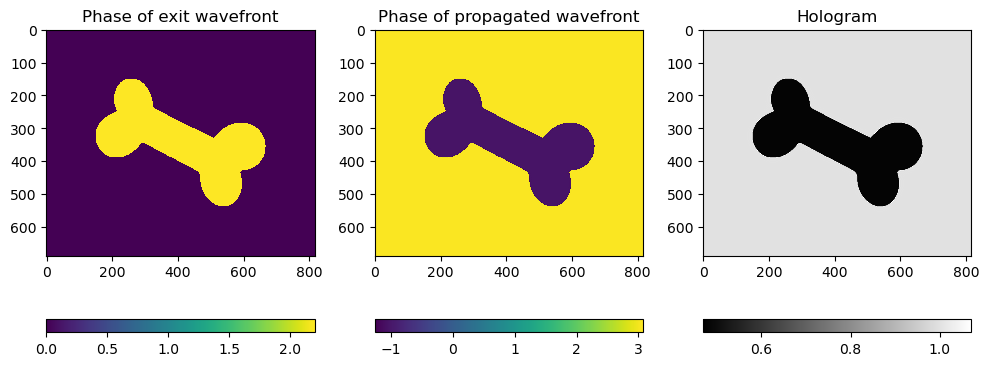

In [6]:
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.title('Phase of exit wavefront')
plt.imshow(np.angle(exit_wavefront), cmap='viridis')
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Phase of propagated wavefront')
plt.imshow(np.angle(wavefront_prop), cmap = 'viridis')
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('Hologram')
plt.imshow(hologram)
plt.colorbar(orientation='horizontal')
plt.tight_layout()

Now, retrieve the phase and compare it to the initial phase of the exit wavefront. 

In [7]:
def thickness(a, mu, delta, z, px):
    '''
    Retrieve object thickness from Weitkamp et al. paper.
    
    Parameters
    ----------
    a : 2D-array
        Input image.
    mu : float
        Linear attenuation coefficient.
    delta : float
        Real part of the complex refractive index.
    z : float
        Distance between the object and the detector.
    
    Returns
    ----------
    out : 2D-array
        Returns estimated phase values.
    '''
    sh = a.shape
    u = 2 * np.pi * np.fft.fftfreq(sh[0], d=px)
    v = 2 * np.pi * np.fft.fftfreq(sh[1], d=px)
    uu, vv = np.meshgrid(u,v, indexing='ij')
    uv2 = uu**2 + vv**2
    
    num = np.fft.fftn(a)
    denom = 1 + ( z * delta / mu ) * uv2 
    
    return -1 / mu * np.log( np.real( np.fft.ifftn( num / denom ) ) ) 

def pbi(a, b, z, lam, px):
    '''
    PBI phase retrieval, Paganin filter.
    
    Parameters
    ----------
    a : 2D-array
        Input image.
    b : float
        PBI parameter delta/beta.
    z : float
        Distance between the object and the detector.
    lam : float
        Wavelength.
    px : float
        pixel size.
    
    Returns
    ----------
    out : 2D-array
        Returns estimated phase values.
    '''
    sh = a.shape
    u = 2. * np.pi * np.fft.fftfreq(sh[0], d=px)
    v = 2. * np.pi * np.fft.fftfreq(sh[1], d=px)
    uu, vv = np.meshgrid(u,v, indexing='ij')
    uv2 = uu**2 + vv**2
    
    num = np.fft.fftn(a)
    denom = 1. + (0.25 * b * lam * z / np.pi ) * uv2 
    
    return 0.5 * b * np.log( np.real( np.fft.ifftn( num / denom ) ) )

In [8]:
# phase retrieved with Weitkamp's formula
img_pbi = pbi(hologram, b=n['delta']/n['beta'], z=z, lam=lam, px=px) 

# phase retrieved via thickness and formula from Paganin
img_pbi2 = - np.pi * 2 * n['delta'] * thickness(hologram, mu = n['mu'], delta = n['delta'], z = z, px = px) / lam

# thickness
img_th = thickness(hologram, mu = n['mu'], delta = n['delta'], z = z, px = px)

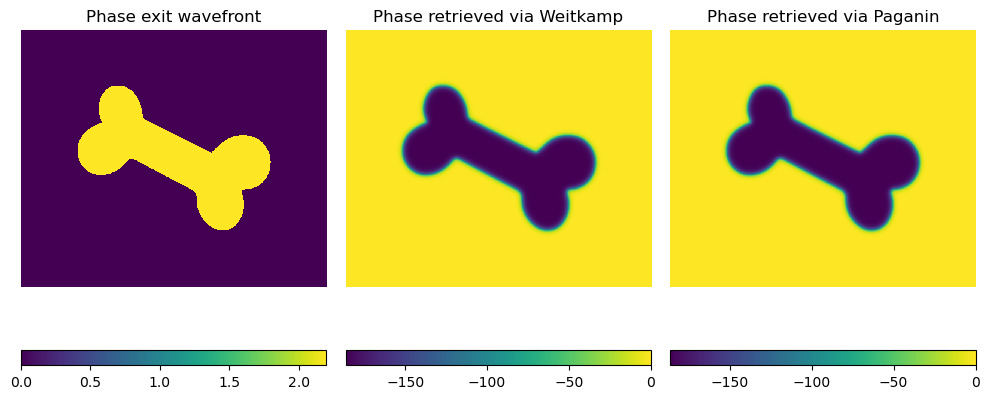

In [9]:
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.title('Phase exit wavefront')
plt.imshow(np.angle(exit_wavefront), cmap='viridis')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Phase retrieved via Weitkamp')
plt.imshow(img_pbi, cmap='viridis')
#plt.imshow(np.angle(np.exp(1.j* img_pbi)), cmap = 'viridis')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('Phase retrieved via Paganin')
plt.imshow((img_pbi2), cmap = 'viridis')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.tight_layout()

We can show that the retrieved phase and the phase-shift introduced by the sample are equivalent:

In [10]:
exit_phase = np.angle(exit_wavefront[330,400])
pag_phase = np.angle(np.exp(1j*img_pbi[330,400]))
                     
print(exit_phase, pag_phase)

2.197854361981421 2.1998738370754936


### Experimental data

Now, we will look at the same experimental data from the last exercise, but this time will try to retrieve the phase. The image was taken at a synchrotron.

We are going to go about this in two ways:
1) We are going to use that we know which material the rods are made from, which gives us $\frac{\delta}{\beta}$. Does this sample fulfil all the assumptions for this method? If not, how will that influence the result?
2) The second approach is more widely used: Usually the precise composition of the sample is not known, therefore the ratio $\frac{\delta}{\beta}$ is empirically determined, by using the ratio that delivers the best image. This may not be the theoretical $\frac{\delta}{\beta}$ from the material.

#### 1) Using the theoretical $\delta/\beta$ ratio directly

Now, following the same steps as for the thickness retrieval last week, reconstruct the phase images of this projection taken at a synchrotron (data from [Savatovic et al.](https://doi.org/10.1088/1748-0221/18/11/C11020)).

![title](phantom_T-pc.png)

In [11]:
# keep the experimental parameters
E = 20 # monochromatic from synchrotron 
lam = 1.24e-9/E
px = 1.28e-6
z = 175e-3

In [12]:
pmma = get_n('Polymethyl Methacralate (Lucite, Perspex)', E)
ptfe = get_n('Polytetrafluoroethylene (Teflon)', E)
pctfe = get_n('Polytrifluorochloroethylene', E)
nylon = get_n('Nylon, type 6 and type 6/6', E)

In [13]:
materials = [pmma, ptfe, pctfe, nylon]
diameters = [1e-3, 1e-3, 1.6e-3, 1.6e-3]

In [14]:
img = tifffile.imread('phantom.tiff')

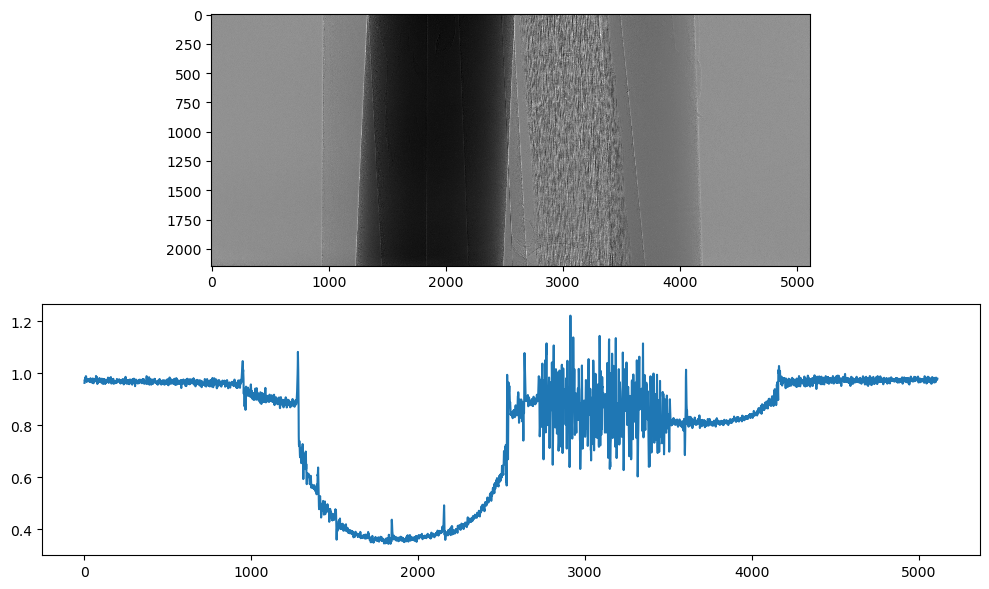

In [15]:
plt.figure()
plt.subplot(211)
plt.imshow(img)
plt.subplot(212)
plt.plot(img[1100])
plt.tight_layout()

In [16]:
imgs_pbi = [pbi(img, b=m['delta']/m['beta'], z=z, lam=lam, px=px) for m in materials]

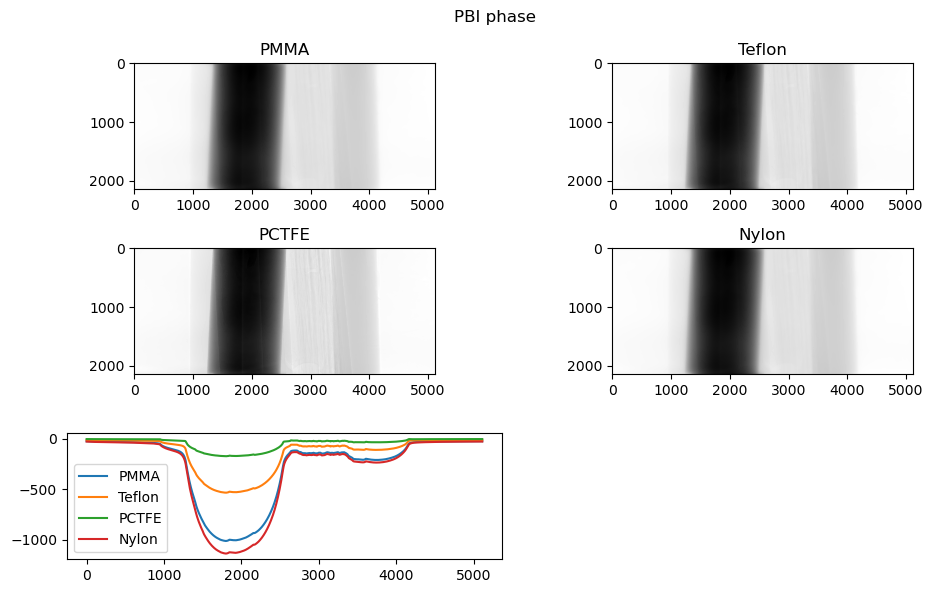

In [17]:
plt.figure()
plt.suptitle('PBI phase')
ax1 = plt.subplot(321)
plt.title('PMMA')
ax1.imshow(imgs_pbi[0])
ax2 = plt.subplot(322, sharex = ax1, sharey = ax1)
plt.title('Teflon')
ax2.imshow(imgs_pbi[1])
ax3 = plt.subplot(323, sharex = ax1, sharey = ax1)
plt.title('PCTFE')
ax3.imshow(imgs_pbi[2])
ax4 = plt.subplot(324, sharex = ax1, sharey = ax1)
plt.title('Nylon')
ax4.imshow(imgs_pbi[3])
plt.subplot(325)
plt.plot(imgs_pbi[0][1100], label='PMMA')
plt.plot(imgs_pbi[1][1100], label='Teflon')
plt.plot(imgs_pbi[2][1100], label='PCTFE')
plt.plot(imgs_pbi[3][1100], label='Nylon')
plt.legend()
plt.tight_layout()

How do the phase reconstructions differ from each other? 

#### 2) Empirically determining an optimal $\delta/\beta$ ratio

Now, we pretend we don't know the composition of the sample and try out different ratios $\delta/\beta$. Choose the ratio that gives the visually best compromise between reduced edge enhancement and resolution loss. Take a look at the ratio for different materials to get a feeling for the orders of magnitude.

In [18]:
ratio = [m['delta']/m['beta'] for m in materials]
print(ratio)
db_emp = np.arange(200,3000,500)
print(db_emp)

[1986.365452074881, 1045.5855226895121, 337.9805001567189, 2232.0451636507]
[ 200  700 1200 1700 2200 2700]


In [19]:
pbi_emp = [pbi(img, b=db_emp[r], z=z, lam=lam, px=px) for r in range(len(db_emp))]

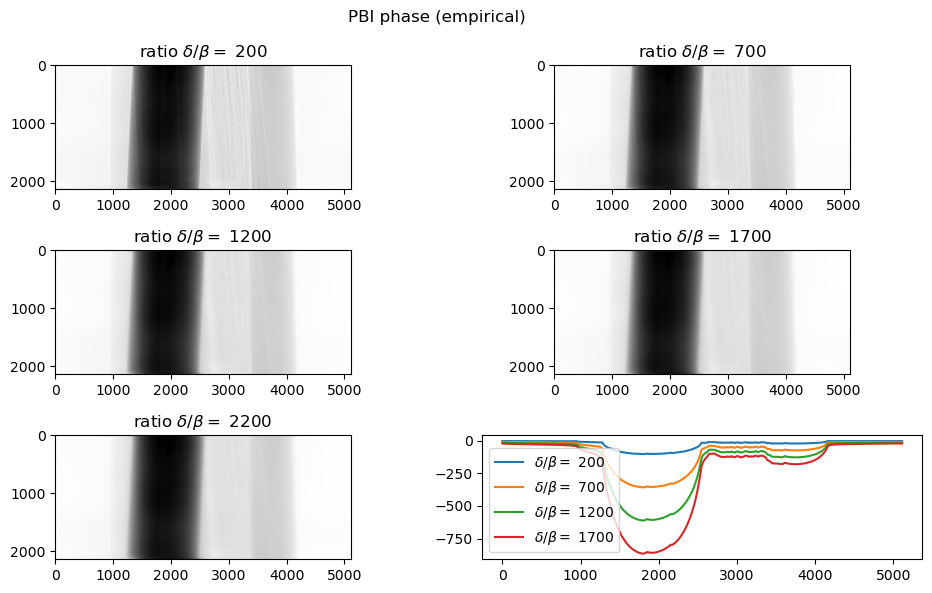

In [20]:
plt.figure()
vmin = -500
vmax = 0
plt.suptitle('PBI phase (empirical)')
ax1 = plt.subplot(321)
plt.title(r'ratio $\delta/\beta =$ {}'.format(db_emp[0]))
ax1.imshow(pbi_emp[0])
ax2 = plt.subplot(322, sharex = ax1, sharey = ax1)
plt.title(r'ratio $\delta/\beta =$ {}'.format(db_emp[1]))
ax2.imshow(pbi_emp[1])
ax3 = plt.subplot(323, sharex = ax1, sharey = ax1)
plt.title(r'ratio $\delta/\beta =$ {}'.format(db_emp[2]))
ax3.imshow(pbi_emp[2])
ax4 = plt.subplot(324, sharex = ax1, sharey = ax1)
plt.title(r'ratio $\delta/\beta =$ {}'.format(db_emp[3]))
ax4.imshow(pbi_emp[3])
ax5 = plt.subplot(325, sharex = ax1, sharey = ax1)
plt.title(r'ratio $\delta/\beta =$ {}'.format(db_emp[4]))
ax5.imshow(pbi_emp[4])
plt.subplot(326)
plt.plot(pbi_emp[0][1100], label=r'$\delta/\beta =$ {}'.format(db_emp[0]))
plt.plot(pbi_emp[1][1100], label=r'$\delta/\beta =$ {}'.format(db_emp[1]))
plt.plot(pbi_emp[2][1100], label=r'$\delta/\beta =$ {}'.format(db_emp[2]))
plt.plot(pbi_emp[3][1100], label=r'$\delta/\beta =$ {}'.format(db_emp[3]))
plt.legend()
plt.tight_layout()

Which ratio would you suggest? Why? Is this result quantitative?

Now, we apply the Paganin phase-retrieval not on a 2D projection image, but on a three-dimensional tomography. The data was binned 4 times, since its original size would be too large to handle without computing servers. First, we define our phase-retrieval function in three dimensions. The kernel is now
$$
\varphi(x,y,z) = \frac{\delta}{2\beta}\text{ln}\bigg(\mathcal{F}^{-1}\bigg\{\frac{\mathcal{F}[I(x,y,z)/I_0(x,y,z)]}{1+[\lambda z \delta/4\pi\beta](u^2 + v^2 + w^2)}\bigg\}\bigg).
$$

In [21]:
def pbi_3D(a, b, z, lam, px):
    '''
    PBI phase retrieval to apply to volumes, Paganin filter.
    
    Parameters
    ----------
    a : 2D-array
        Input image.
    b : float
        PBI parameter delta/beta.
    z : float
        Distance between the object and the detector.
    lam : float
        Wavelength.
    px : float
        Pixel size.
    
    Returns
    ----------
    out : 2D-array
        Returns estimated phase values.
    '''
    # build coordinate grid as seen for the 2D case
    import scipy.fft as fft
    sh = a.shape
    i = 2 * np.pi * fft.fftfreq(sh[0], d=px)
    j = 2 * np.pi * fft.fftfreq(sh[1], d=px)
    k = 2 * np.pi * fft.fftfreq(sh[2], d=px)
    ii, jj, kk  = np.meshgrid(i,j,k, indexing='ij')
    u2 = ii**2 + jj**2 + kk**2
    
    #build updated  
    num = np.fft.fftn(a)
    denom = 1 + (0.25 * b * lam * z / np.pi ) * u2 
    
    # Since we are applying it on an attenuation volume where -log(proj) has been done before tomographic reconstruction,
    # we can leave out the -log in the original Paganin function
    return 0.5 * b * np.real( fft.ifftn( num / denom ) ) 
    # Otherwise: -0.5 * b * np.log( np.real( fft.ifftn( num / denom ) ) )

In [22]:
# min -1.5e-7 max 8.5e-7
# this is the ground truth quantitative phase-contrast image we use to compare
vol_pc = tifffile.imread('phantom_tomo_pc_x4_crop.tif') / 255. * (8.5e-7 + 1.5e-7) - 1.5e-7 

In [23]:
# min -500, max 1000
# this is the attenuation image taken that includes edge enhancement (-> near-field regime)
vol_T = np.array(tifffile.memmap('phantom_tomo_x4_crop.tif', mode='r')) / 255. * (1000. + 500.) - 500. 

In [24]:
# generate a phase-contrast image using the paganin phase-retrieval
# use the delta/beta ratio for pctfe
vol_pbi = pbi_3D(vol_T, b=pctfe['delta']/pctfe['beta'], z=z, lam=lam, px=4*px) # The volume is binned 4 times

Show three (same) axial slices of the phantom and compare the image quality and information contained. Assuming the phase-contrast volume measured with speckle-based phase-contrast (more about SBI next week) is the ground truth: how close is the PBI volume? Why might this retrieval not give the correct values?

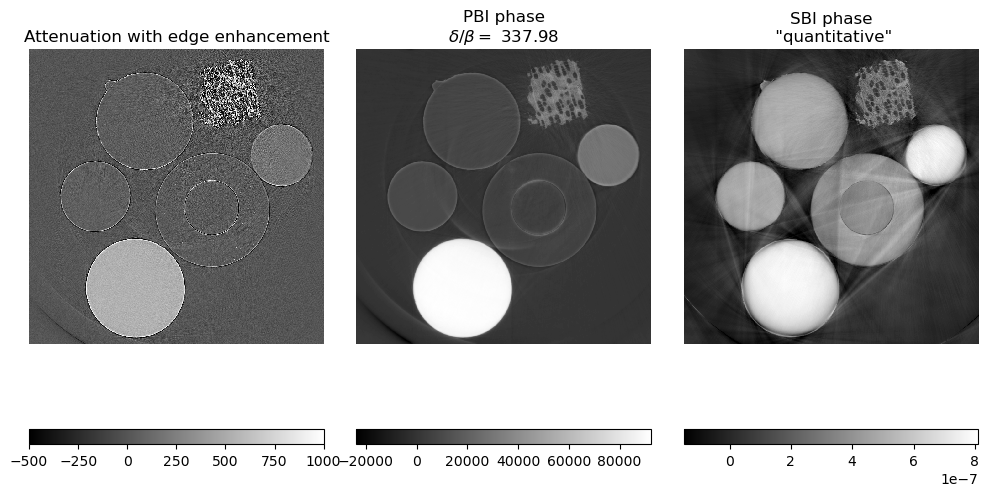

In [25]:
plt.figure()
ax1 = plt.subplot(131)
plt.title('Attenuation with edge enhancement')
im1 = ax1.imshow(vol_T[50])
plt.axis('off')
plt.colorbar(im1, orientation='horizontal')
ax2 = plt.subplot(132, sharex = ax1, sharey = ax1)
plt.title('PBI phase\n'+r'$\delta/\beta =$ {:.2f}'.format(pctfe['delta']/pctfe['beta']))
im2 = ax2.imshow(vol_pbi[50])
plt.axis('off')
plt.colorbar(im2, orientation='horizontal')
ax3 = plt.subplot(133, sharex = ax1, sharey = ax1)
plt.title('SBI phase\n "quantitative"')
im3 = ax3.imshow(vol_pc[50])
plt.axis('off')
plt.colorbar(im3, orientation='horizontal')
plt.tight_layout()

## Multi-distance phase retrieval: Holo-tomography


In in-line holography, the sample is measured at multiple near-field propagation distances from the contact plane. From these several images, the phase is calculated. There are different reconstruction approaches including for example iterative reconstructions (Allen et al. 2001).

Describe the general idea behind the iterative reconstruction approach described in Allen et al. (section 2.3, provided to you with the exercise). Include answers to the following questions:
1) What are the constraints?
   Known intensity at each step. Fresnel propagation.
2) What if the sample has phase discontinuities?
   Iterative reconstruction can manage, though not if too strong (?)
5) Does noise affect the reconstruction?
   Not as strongly as the TIE.
7) Is this method restricted to near-field reconstructions?
   No. Gerchberg-Saxton algorithm for far-field applications.

Holo-tomography is the 3D extension of the method. 

What are experimental challenges you might encounter in performing holography/3D-holo-tomography?
* Misalignment of beam path and sample movement path (not completely in line)
* Not completely parallel beam --> slight cone beam leads to slight magnification which hinders registration
* Noise
* Drift in the motors
* Sample deformation due to high dose deposition